## Libraries

In [2]:
import os
import glob
from pathlib import Path
import random
from collections import Counter # contare (query sql)
import itertools
from joblib import Parallel, delayed

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.utils import plot_model

import librosa
from IPython.display import Audio

## Load dataset

In [3]:
from pathlib import Path

# possibili path (o hai il dataset su drive, o nella working directory)
drive_path = Path('/content/drive/MyDrive/music_dataset') # dani (o metti mini_dataset_100 se vuoi usare il mini-dataset)
local_path = Path('./music_dataset') # tommaso

# automaticamente scelgo path esistente
if drive_path.exists():
    DATA_PATH = drive_path
elif local_path.exists():
    DATA_PATH = local_path
else:
    raise FileNotFoundError(
        f"Nessun dataset trovato in {drive_path} né in {local_path}"
    )

# trovo filepaths (lista dei file .wav) e labels (le y)
filepaths = list(DATA_PATH.rglob('*.wav'))
labels = [p.parent.name for p in filepaths]

print(f"Trovati {len(filepaths)} file audio di {len(set(labels))} classi.")
print(f"Classi: {sorted(set(labels))}")

Trovati 42311 file audio di 28 classi.
Classi: ['Accordion', 'Acoustic_Guitar', 'Banjo', 'Bass_Guitar', 'Clarinet', 'Cymbals', 'Dobro', 'Drum_set', 'Electro_Guitar', 'Floor_Tom', 'Harmonica', 'Harmonium', 'Hi_Hats', 'Horn', 'Keyboard', 'Mandolin', 'Organ', 'Piano', 'Saxophone', 'Shakers', 'Tambourine', 'Trombone', 'Trumpet', 'Ukulele', 'Violin', 'cowbell', 'flute', 'vibraphone']


## Data Analysis

In [4]:
from collections import Counter # hashmap utile

# Numero campioni audio per classe

counts = Counter(labels) # hashmap {classe:#esempi}

for classe, count in counts.items():
    print(f"{classe}: {count}")

# problema: class imbalance
# possiamo risolvere con oversampling delle classi con meno esempi, 
# o direttamente allenando le reti pesando le classi in base a quanti esempi hanno

Accordion: 3581
Acoustic_Guitar: 3654
Banjo: 2998
Bass_Guitar: 3613
Clarinet: 634
cowbell: 621
Cymbals: 208
Dobro: 487
Drum_set: 3648
Electro_Guitar: 1316
Floor_Tom: 406
flute: 3719
Harmonica: 131
Harmonium: 1314
Hi_Hats: 444
Horn: 1258
Keyboard: 2041
Mandolin: 2458
Organ: 1442
Piano: 575
Saxophone: 454
Shakers: 1357
Tambourine: 558
Trombone: 2965
Trumpet: 503
Ukulele: 790
vibraphone: 506
Violin: 630


## Prendo un mini-dataset del dataset (per fare test veloci)

In [6]:
import random

SEED = 69 # nice
random.seed(SEED)
np.random.seed(SEED)

N = 100 # Numero esempi per classe

mini_filepaths = []
mini_labels    = []

for cls in set(labels):
    cls_files = [f for f, lab in zip(filepaths, labels) if lab == cls] # Tutti i file di quella classe
    sampled = random.sample(cls_files, k=min(N, len(cls_files))) # Seleziono N file a caso
    mini_filepaths.extend(sampled)
    mini_labels.extend([cls] * len(sampled))

print(f"Totale file audio del mini-dataset: {len(mini_filepaths)}")

# uso il mini-dataset (commentare se si vuole mini-dataset a parte, senza sovrascrivere quello originale)
filepaths = mini_filepaths
labels = mini_labels

Totale file audio del mini-dataset: 2800


## Preprocessing

### train-val-test split

In [5]:
# split 80-10-10

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X = filepaths
y = labels
SEED = 22

X, y = shuffle(X, y, random_state=SEED)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=SEED
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=SEED
)

print(f"Train: {len(X_train)} ({len(X_train)/len(X):.1%})")
print(f"Val: {len(X_val)} ({len(X_val)/len(X):.1%})")
print(f"Test: {len(X_test)} ({len(X_test)/len(X):.1%})")

Train: 33848 (80.0%)
Val: 4231 (10.0%)
Test: 4232 (10.0%)


### Feature Extraction (mfcc, mfcc_mean, mel_spectrogram)

### Funzioni x feature extraction

In [6]:
# carico features già estratte
data = np.load("mfcc_raw40.npz", allow_pickle=True)
X_train_mfcc_matrix = data["X_train"]
X_val_mfcc_matrix   = data["X_val"]
X_test_mfcc_matrix  = data["X_test"]

In [7]:
# (se voglio usare mfcc_vector)

X_train_mfcc_vector = np.mean(X_train_mfcc_matrix, axis=2) # media lungo asse temporale T
X_val_mfcc_vector   = np.mean(X_val_mfcc_matrix, axis=2)
X_test_mfcc_vector  = np.mean(X_test_mfcc_matrix, axis=2)
# shape: (#samples,n_mfcc=40)

In [8]:
from sklearn.preprocessing import StandardScaler

# 1. Inizializziamo lo scaler
scaler = StandardScaler()

# 2. Fit sul train, transform su train/val/test
X_train_mfcc = scaler.fit_transform(X_train_mfcc_vector)
X_val_mfcc   = scaler.transform(X_val_mfcc_vector)
X_test_mfcc  = scaler.transform(X_test_mfcc_vector)


In [9]:
print("Shapes delle X dopo il preprocessing:", X_train_mfcc.shape, X_val_mfcc.shape, X_test_mfcc.shape)

Shapes delle X dopo il preprocessing: (33848, 40) (4231, 40) (4232, 40)


### Preprocessing per le y

In [10]:
# preprocessing per le y: ohe (le y sono categorical: es. "Violin")

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False, handle_unknown='error')

y_train_ohe = ohe.fit_transform(np.array(y_train).reshape(-1, 1))
y_val_ohe   = ohe.transform(np.array(y_val).reshape(-1, 1))
y_test_ohe  = ohe.transform(np.array(y_test).reshape(-1, 1))

## Models

In [11]:
# 1) Import e metriche
from sklearn.linear_model    import LogisticRegression
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.metrics         import accuracy_score, classification_report, confusion_matrix

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "KNN":                KNeighborsClassifier(n_neighbors=5, weights="distance"),
    "RandomForest":       RandomForestClassifier(n_estimators=200, n_jobs=-1),
}

results = {}
for name, clf in models.items():
    # Fit sul train
    clf.fit(X_train_mfcc, y_train)
    # Predizione su validation (o test)
    y_test_pred = clf.predict(X_test_mfcc)
    acc = accuracy_score(y_test, y_test_pred)
    results[name] = acc
    print(f"--- {name} ---")
    print(f"Accuracy: {acc:.3f}")
    print(classification_report(y_test, y_test_pred))
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_test_pred))
    print()


--- LogisticRegression ---
Accuracy: 0.871
                 precision    recall  f1-score   support

      Accordion       0.81      0.65      0.72       358
Acoustic_Guitar       0.91      0.76      0.83       366
          Banjo       0.85      0.85      0.85       300
    Bass_Guitar       1.00      1.00      1.00       362
       Clarinet       0.61      0.83      0.70        64
        Cymbals       0.28      0.60      0.38        20
          Dobro       0.70      0.96      0.81        48
       Drum_set       1.00      1.00      1.00       365
 Electro_Guitar       0.73      0.80      0.76       132
      Floor_Tom       0.56      0.88      0.68        40
      Harmonica       0.87      1.00      0.93        13
      Harmonium       1.00      0.99      1.00       132
        Hi_Hats       0.70      0.89      0.78        44
           Horn       1.00      1.00      1.00       126
       Keyboard       1.00      1.00      1.00       204
       Mandolin       0.74      0.72      0.

In [12]:
# 2) Riepilogo accuracies
import pandas as pd
print(pd.Series(results))

LogisticRegression    0.870983
KNN                   0.969282
RandomForest          0.970227
dtype: float64


C:\Users\tomma\AppData\Local\Temp\ipykernel_6892\1479904391.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(le.classes_))


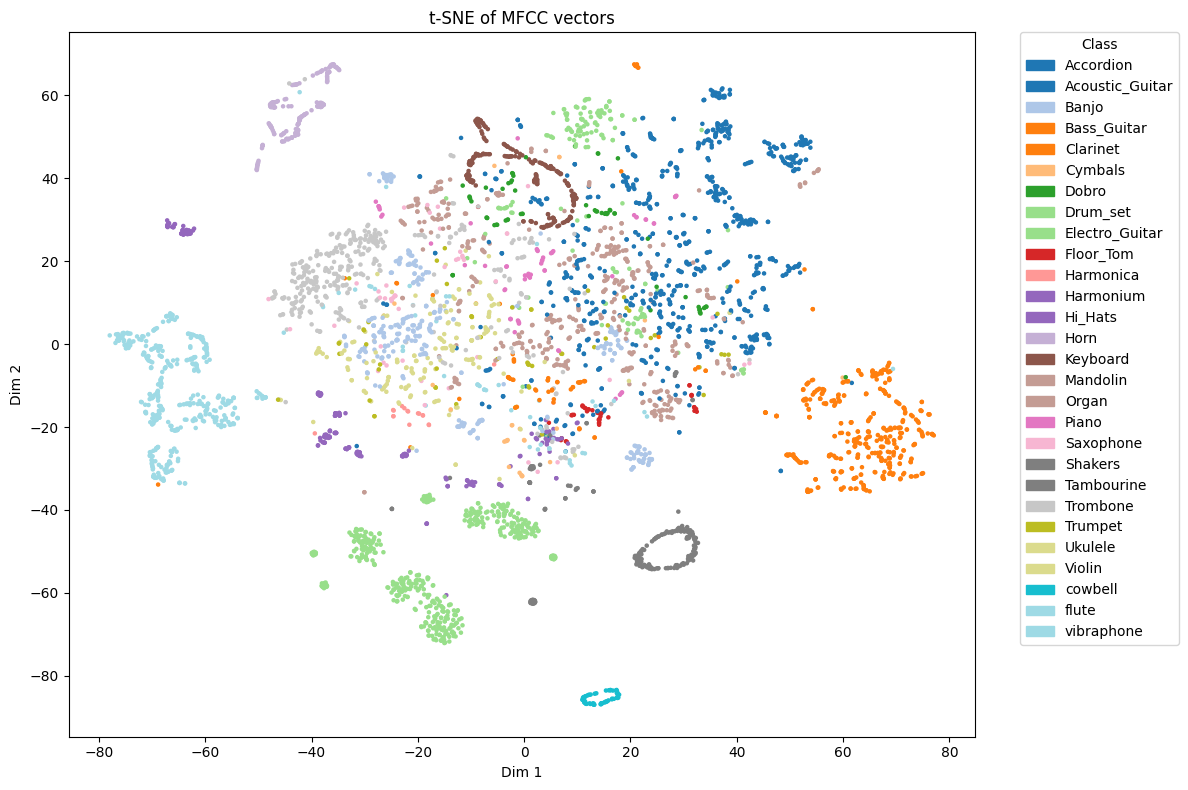

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold       import TSNE
import matplotlib.pyplot    as plt
import numpy                as np
from matplotlib.patches     import Patch

# 1) Encode delle etichette in interi
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)   # codifica string→0…27

# 2) Sottoinsieme casuale (fino a 5000 campioni)
n_plot = min(5000, X_train_mfcc.shape[0])
idx    = np.random.choice(X_train_mfcc.shape[0], size=n_plot, replace=False)
X_sub  = X_train_mfcc[idx]
y_sub  = y_train_enc[idx]

# 3) t-SNE in 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
X_2d = tsne.fit_transform(X_sub)

# 4) Scatter plot colorato
plt.figure(figsize=(12,8))
scatter = plt.scatter(
    X_2d[:,0], X_2d[:,1],
    c=y_sub, cmap='tab20', s=5
)

# 5) Legenda completa per tutte le classi
#    Creiamo un patch per ciascuna label, usando lo stesso colormap tab20
cmap = plt.cm.get_cmap('tab20', len(le.classes_))
patches = [
    Patch(color=cmap(i), label=label)
    for i, label in enumerate(le.classes_)
]

plt.legend(
    handles=patches,
    bbox_to_anchor=(1.05,1),
    loc='upper left',
    borderaxespad=0,
    title="Class"
)

plt.title("t-SNE of MFCC vectors")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
plt.show()